# Molecule exploration by VAE

In [1]:
import joblib
import numpy as np
import sys
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os
from tqdm.notebook import tqdm
import datetime


sys.path.append("../lib/")
from ScaleRegressor import ScaleRegressor
from JTNNWrapper import JTNNWrapper


jtnn = JTNNWrapper()

Using backend: pytorch
RDKit WARNING: [14:48:16] Enabling RDKit 2019.09.3 jupyter extensions


Pretrained model loaded


# Regression
    - Calculate slope for a linear regression model

In [2]:
# init variables and files
def init(cond):
    cond["project_code"] = str(datetime.date.today(
    ))+"_"+str(len(cond["start_smiles"]))+"chems_"+cond["target_param_name"]
    cond["save_path"] = "vae_results/"+cond["project_code"]
    cond["sample_num"] = 10

    # makedir
    if not os.path.exists(cond["save_path"]):
        os.mkdir(cond["save_path"])

    joblib.dump(cond, cond["save_path"]+"/setting")


# load database and get X and y for regression
def get_X_y(file_path, smiles_column, target_param_name):
    # load DB
    df = pd.read_csv(file_path)
    df = df[[smiles_column, target_param_name]]
    df = df.dropna()

    smiles_list = list(df[smiles_column].values)
    y_array = np.array(df[target_param_name].values)

    # to_vec
    vec_path = "jtnn_vec.bin"

    if os.path.exists(vec_path):
        vec_array = joblib.load(vec_path)
        print("vectors loaded")
    else:
        vec_array = jtnn.encode(smiles_list)
        joblib.dump(vec_array, vec_path)

    # delete broken smiles
    available_ids = list(set(np.where(vec_array != 0)[0]))
    vec_array = vec_array[available_ids]
    y_array = y_array[available_ids]

    return vec_array, y_array


def regress(vec_array, y_array):
    model = ScaleRegressor()
    model.fit(vec_array, y_array)
    p_tr_y = model.predict(vec_array)

    plt.figure(figsize=(4, 4))
    plt.scatter(y_array, p_tr_y, s=3)
    return model

# Search new molecules by VAE

In [3]:
import timeout_decorator
n_samples = 20


@timeout_decorator.timeout(5)
def decode(vec):
    sm = jtnn.decode(vec)[0]
    return sm


#sample new chemical by adding slope of regression model
def vae_sampling(start_smiles):

    #encode
    model_vecs = jtnn.encode(start_smiles)

    log_list = []
    for i in tqdm(range(n_samples)):
        
        #make initial vector. 
        w = np.random.uniform(0, 1, len(start_smiles))
        w = w/np.sum(w)
        alpha = random.uniform(0, 10)
        noise_coeff = random.uniform(0, 1)
        original_vec = np.dot(w, model_vecs)

        # add slope of regression model
        vec = model.scaler_X.transform(
            original_vec.reshape(-1, jtnn.model.latent_size))
        vec += alpha*model.coef_.reshape(-1, vec.shape[1])
        
        #add random noise
        noise = np.random.randn(vec[0].shape[0])
        vec += noise*noise_coeff

        vec = model.scaler_X.inverse_transform(vec)
        vec = vec.astype(np.float32)

        #decode
        try:
            sm = decode(vec)
            # print(sm)
            if sm is not None and sm != "Error":
                log = (w, alpha, noise_coeff, sm)
                log_list.append(log)
        except TimeoutError:
            print("timeout")
        # print(sm)

    return log_list

In [5]:
#set conditions
cond={}
cond["type"]="vae_results/"
cond["smiles_column"]="SMILES"
cond["target_param_name"]="MolLogP"
cond["database_path"]="../database/BradleyDoublePlusGoodMeltingPointDataset_logP.csv"
cond["start_smiles"]=["Cc1ccccc1","FC(F)(F)F"]

Loading data...
Loading finished
	# samples: 3025


  0%|          | 0/3025 [00:00<?, ?it/s]

error
error
error
error


/home/user/anaconda3/envs/da37/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Loading data...
Loading finished
	# samples: 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

error! 0


/home/user/anaconda3/envs/da37/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)
/home/user/anaconda3/envs/da37/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)


error! 0


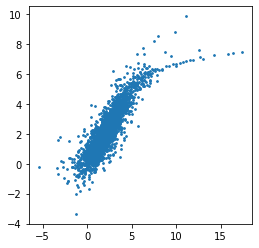

In [6]:
vec_array,y_array=get_X_y(cond["database_path"],cond["smiles_column"],cond["target_param_name"])
model=regress(vec_array,y_array)
log_list=vae_sampling(cond["start_smiles"])

In [8]:
#show results
#w, alpha, noise_coeff, sm
log_list

[(array([0.63945198, 0.36054802]),
  7.662724477798379,
  0.747090625015604,
  'CCc1cc(Cl)cc2c1CCc1cccc(-c3ccc(C4=CCOc5ccccc54)cc3)c1-2'),
 (array([0.52296956, 0.47703044]),
  4.628870878105968,
  0.4451051930339305,
  'Cc1ccc2c(c1Cl)-c1ccccc1OC2'),
 (array([0.23851632, 0.76148368]),
  0.5111393321162527,
  0.21897480469157937,
  'FC(F)(F)c1ccccc1'),
 (array([0.69845675, 0.30154325]),
  3.541706159088948,
  0.9873002407788676,
  'Cc1ccc(N2CCS[C@@H](CC(C)C)CC2)cc1'),
 (array([0.89572679, 0.10427321]),
  0.9539728795038827,
  0.25086288668905976,
  'Cc1ccc(F)cc1'),
 (array([0.87633512, 0.12366488]),
  1.1549846622469162,
  0.8892556715410697,
  'Cc1ccc(N(C)N2CCCC2)cc1'),
 (array([0.59436333, 0.40563667]),
  0.06695667494251767,
  0.061616404281606973,
  'Cc1ccc(F)cc1')]